In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [86]:
m1="CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv"
t1="CIC-IDS-2017/Tuesday-WorkingHours.pcap_ISCX.csv"
w1="CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv"
th1="CIC-IDS-2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
th2="CIC-IDS-2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f1="CIC-IDS-2017/Friday-WorkingHours-Morning.pcap_ISCX.csv"
f2="CIC-IDS-2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f3="CIC-IDS-2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"

dm1 = pd.read_csv(m1)
dt1 = pd.read_csv(t1)
dw1 = pd.read_csv(w1)
dth1 = pd.read_csv(th1)
dth2 = pd.read_csv(th2)
df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)

In [97]:
df = pd.concat([dm1,dt1,dw1,dth1,dth2,df1, df2, df3], axis=0)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

In [98]:
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

class_names=le.classes_

In [99]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:

class CICDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        # Check if input is a pandas DataFrame or Series, and convert accordingly
        if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
            self.data = torch.tensor(data.values, dtype=torch.float32)
        else:  # If it's already a NumPy array
            self.data = torch.tensor(data, dtype=torch.float32)
        
        if isinstance(labels, pd.DataFrame) or isinstance(labels, pd.Series):
            self.labels = torch.tensor(labels.values, dtype=torch.long)
        else:  # If it's already a NumPy array
            self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [108]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TrafficLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TrafficLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # LSTM layer
        out, (hn, cn) = self.lstm(x)
        # `hn` is [1, batch_size, hidden_size]; extract the first dimension
        out = self.fc(hn.squeeze(0))  # Shape [batch_size, num_classes]
        return out



In [103]:
print(type(X_train), type(y_train))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [104]:
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()


In [105]:
batch_size = 64
train_dataset = CICDataset(X_train, y_train)
test_dataset = CICDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Model hyperparameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # Size of the LSTM hidden state
num_classes = len(class_names)   # Number of network traffic classes (normal, DoS, etc.)

# Initialize the model
model = TrafficLSTM(input_size, hidden_size, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [109]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Reshape inputs to [batch_size, 1, input_size]
        inputs = inputs.unsqueeze(1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Shape [batch_size, num_classes]
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/10, Loss: 0.4517657458782196
Epoch 2/10, Loss: 0.3693339228630066
Epoch 3/10, Loss: 0.3470749855041504
Epoch 4/10, Loss: 0.24514783918857574
Epoch 5/10, Loss: 0.536149263381958
Epoch 6/10, Loss: 0.1952941119670868
Epoch 7/10, Loss: 0.3090208172798157
Epoch 8/10, Loss: 0.40504583716392517
Epoch 9/10, Loss: 0.09767943620681763
Epoch 10/10, Loss: 0.35833361744880676


In [ ]:
torch.save(model.state_dict(), "models/pytorch_LSTM.pth")
print("Model saved successfully.")

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.unsqueeze(1).to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1) 
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)

    precision = precision_score(y_true, y_pred, average='weighted')  
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4, target_names=class_names))



Test Accuracy: 0.8688


c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.8552
Recall: 0.8688
F1 Score: 0.8545


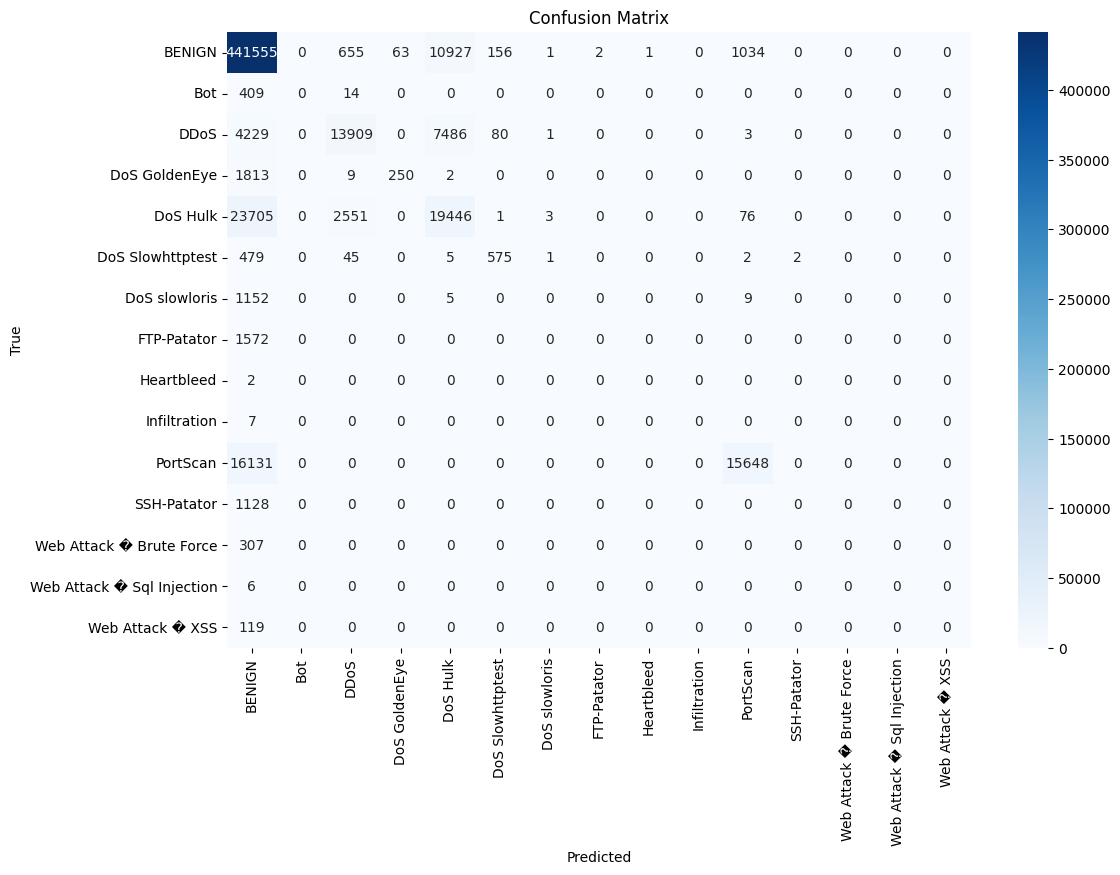


Classification Report:
                             precision    recall  f1-score   support

                    BENIGN     0.8964    0.9717    0.9325    454394
                       Bot     0.0000    0.0000    0.0000       423
                      DDoS     0.8095    0.5410    0.6486     25708
             DoS GoldenEye     0.7987    0.1205    0.2095      2074
                  DoS Hulk     0.5135    0.4248    0.4649     45782
          DoS Slowhttptest     0.7081    0.5185    0.5986      1109
             DoS slowloris     0.0000    0.0000    0.0000      1166
               FTP-Patator     0.0000    0.0000    0.0000      1572
                Heartbleed     0.0000    0.0000    0.0000         2
              Infiltration     0.0000    0.0000    0.0000         7
                  PortScan     0.9330    0.4924    0.6446     31779
               SSH-Patator     0.0000    0.0000    0.0000      1128
  Web Attack � Brute Force     0.0000    0.0000    0.0000       307
Web Attack � Sql Injec

c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [113]:
evaluate_model(model, test_loader, device)